## Demo PyHeat Val_direct

MOLONARI 2022 créé par Guillaume de Rochefort

Ceci est un notebook de démo pour la récupération de valeur de température d'après la solution numérique des équations hydrothermiques. Based on the ``Time_series`` class in ``time_series.py``

In [1]:
from pyheatmy import *
import matplotlib.pyplot as plt
import numpy as np

## 0. Variables globales de l'expérience
Variables temporelles, nombre de cellules de colonne, paramètres de couche

In [2]:
# paremètres de l'expérience
t_debut = (2011, 8, 1)
t_fin = (2011, 8, 31, 23, 59, 59)
dt = 15*60 # pas de temps en (s)

T_riv_amp = 4
T_riv_offset = 20
P_T_riv = 7*24*4*dt

T_aq_amp = 0
T_aq_offset = 20
P_T_aq = 9999 # à mettre dans le init

dH_amp = 0
dH_offset = -1
P_dh = -9999 #14*24*4*dt

nb_cells = 100
depth_sensors = [.1, .2, .3, 1]
moinslog10IntrinK = 12
n = .1
lambda_s = 2
rho_cs = 4e6


## 1. Définition de l'expérience
Une fonction de définition de l'expérience a été codée dans le notebook cas test

Initializing time series of synthetic_MOLONARI
param_time_dates: [(2011, 8, 1), (2011, 8, 31, 23, 59, 59), 900]
param_dH_signal: [0, -9999, -1]
param_T_riv_signal: [4, 604800, 20]
param_T_aq_signal: [0, 9999, 20]
sigma_meas_P: 0.05
sigma_meas_T: 0.1
Entering Hydraulic head differential generation with amplitude 0, period of -9999, offset -1, dt 900 --> 
constant signal

Entering T_riv generation with amplitude 4, period of 604800, offset 20, dt 900 --> 
periodic signal



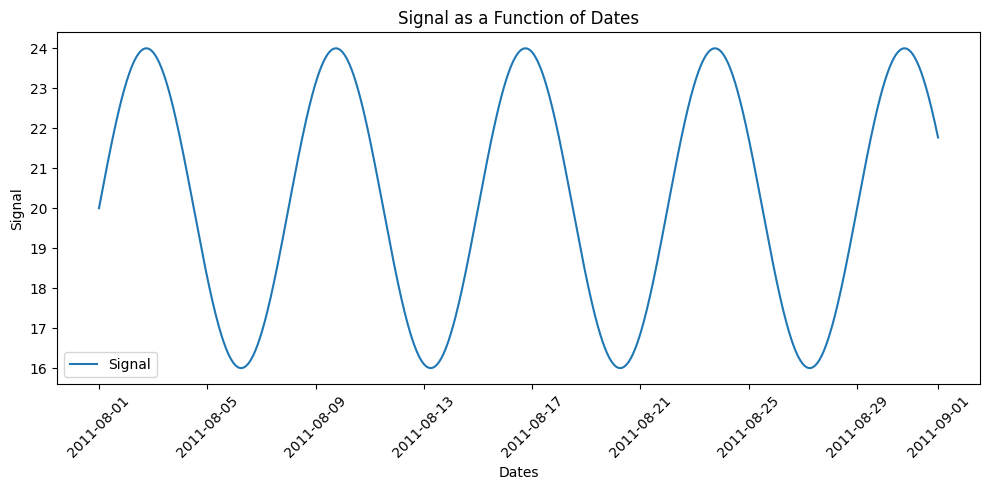

Entering T_aq generation with amplitude 0, period of 9999, offset 20, dt 900 --> 
periodic signal



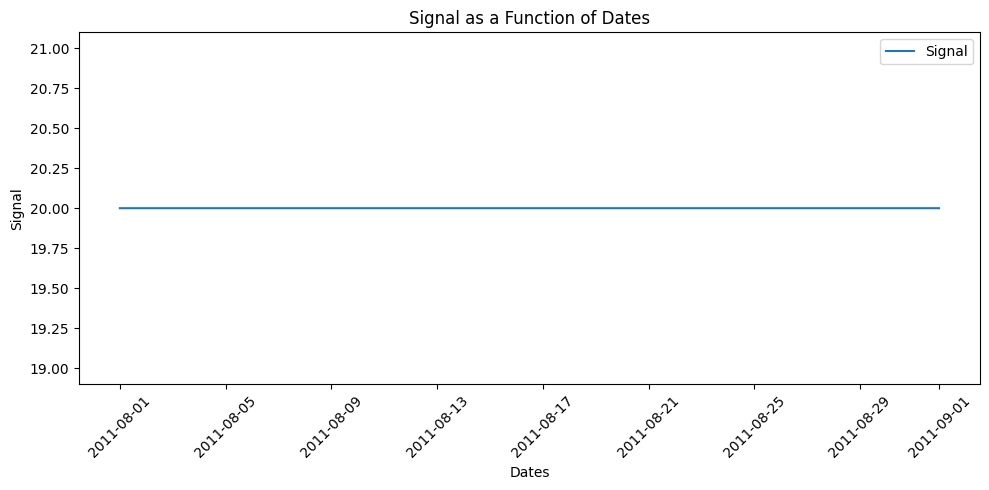

Generating Shaft with 4 sensors
4 sensors in the shaft
Temperature of Sensor 0 : [20.         20.03365943 20.06731592 ... 21.65233471 21.62235791
 21.59223928]
Temperature of Sensor 1 : [20.         20.02991949 20.05983637 ... 21.46874197 21.44209592
 21.41532381]
Temperature of Sensor 2 : [20.         20.02617956 20.05235683 ... 21.28514922 21.26183393
 21.23840833]
Temperature of Sensor 3 : [20. 20. 20. ... 20. 20. 20.]


UFuncTypeError: Cannot cast ufunc 'add' output from dtype('float64') to dtype('int64') with casting rule 'same_kind'

In [3]:
# définition de l'expérience 

"""Times series"""
time_series_dict = {
    "offset" : 0,
    "depth_sensors":depth_sensors,
	"param_time_dates": [t_debut, t_fin, dt], 
    "param_dH_signal": [dH_amp, P_dh, dH_offset], #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
	"param_T_riv_signal": [T_riv_amp, P_T_riv, T_riv_offset],
    "param_T_aq_signal": [T_aq_amp, P_T_aq, T_aq_offset],
    "sigma_meas_P": 0.05,
    "sigma_meas_T": 0.1, #float
}
time_series = synthetic_MOLONARI.from_dict(time_series_dict)
time_series._generate_all_series(verbose=False)

"""Colonne"""
col_dict = {
	"river_bed": 1., 
    "depth_sensors": depth_sensors, #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
	"offset": .0,
    "dH_measures": time_series._molonariP_data,
    "T_measures": time_series._T_Shaft_measures,
    "sigma_meas_P": time_series._sigma_P, #float
    "sigma_meas_T": time_series._sigma_T, #float
}
colonne_exp = Column.from_dict(col_dict)

"""Layer"""
monolayer_dict = {
    "name": "sable",
    "zLow": depth_sensors[-1],
    "moinslog10IntrinK": moinslog10IntrinK,
    "n": n,
    "lambda_s": lambda_s,
    "rhos_cs": rho_cs
}
monolayer = Layer.from_dict(monolayer_dict)


"""Valeurs analytiques"""
analy_sol_dict = {
    "column_exp" : colonne_exp,
    "time_series" : time_series,
    "monolayer" : monolayer,
    "nb_cells" : nb_cells,
}

## 2. Démonstration de la fiabilité du modèle direct avec les solutions analytiques générales
L'utilisateur expert peut réaliser d'autres test en utilisant les objets générés.

### 2.1 Calcul du RMSE

In [4]:
analy_sol_exp = Analy_Sol.from_dict(analy_sol_dict)

# MAJ des attributs de l'objet
analy_sol_exp.compute_temp_general()
analy_sol_exp.compute_temp_cond()
analy_sol_exp.generate_RMSE_analytical(time_series, colonne_exp, monolayer)

NameError: name 'analy_sol_dict' is not defined

### 2.2 Comparaison visuelle du modèle direct et de la solution analytique

In [ ]:
t_fin =1500

for i,id_sens in enumerate(analy_sol_exp._id_sensors) :
    plt.plot(analy_sol_exp.analy_temp_general[id_sens,:t_fin],label="Tanaly{}".format(i+1))
    plt.plot(time_series._T_Shaft[:t_fin,i],linestyle="--",label="Tmd{}".format(i+1))
plt.legend()
plt.grid()

### 2.3 Comparaison de la différence entre modèle direct et solution analytique en temporel

In [ ]:
for i,id_sens in enumerate(analy_sol_exp._id_sensors) :
    plt.plot(analy_sol_exp.analy_temp_general[id_sens,:]-time_series._T_Shaft[:,i],label="T{}".format(i+1))
plt.legend()
plt.grid()

### 2.4 Comparaison du modèle direct et de la solution analytique en profil de température

In [ ]:
# l'utilisateur peut changer l'instant d'observation du profil
t_obs = 0

plt.plot(analy_sol_exp.analy_temp_cond[:,t_obs],-analy_sol_exp._z_solve, label='Analy')
plt.plot(colonne_exp.temperatures_solve[:,t_obs],-analy_sol_exp._z_solve, label='MD')
plt.plot(time_series._T_Shaft[t_obs],-np.array(colonne_exp.depth_sensors), marker='o',label='Tshaft variable')
plt.legend()
plt.grid()
plt.title("Profils de températures à t={}".format(t_obs))
plt.xlabel("T(°C)")
plt.ylabel("z(m)")

In [8]:
import matplotlib.animation as animation
from IPython import display

# initializing a figure
fig = plt.figure()
  
# labeling the x-axis and y-axis
axis = plt.axes(xlim=(15.5, 25),  ylim=(-1.05,0))
axis.grid()
axis.set_title("Profils de températures à t=0")
axis.set_xlabel("T(°C)")
axis.set_ylabel("z(m)")
line1, = axis.plot(0,0, label="analytical solution")
line2, = axis.plot(0,0,ls="--", label="direct model solution")
line3, = axis.plot(0,0,'o',ls="-." , label="sensors positions")
axis.legend()
fig.suptitle('Profils de températures', fontsize=14)

line1.set_ydata(-analy_sol_exp._z_solve)
line2.set_ydata(-analy_sol_exp._z_solve)
line3.set_ydata(-np.array(colonne_exp.depth_sensors))
def animate(frame_number):
    axis.set_title("Profils de températures à t={}".format(frame_number))
    line1.set_xdata(analy_sol_exp.analy_temp_cond[:,frame_number])
    line2.set_xdata(colonne_exp.temperatures_solve[:,frame_number])
    line3.set_xdata(time_series._T_Shaft[frame_number])
    return line1,line2,line3,

anim = animation.FuncAnimation(fig, animate, frames=1000, 
                               interval=200, blit=True)

# saving to m4 using ffmpeg writer
writervideo = animation.PillowWriter(fps=28)
anim.save(f'{colonne_exp._dir_print}/time_temp_profile.gif', writer=writervideo)
plt.close()

